# Bloqade Tutorial

This document is a elementary introduction to programming neutral-atom analog quantum processors with Bloqade. The goal is to bring the reader "from 0 to 1", demonstrating in a single step how simple solving problems can be with Bloqade. 

## Installation requirements and guidelines
For general details on Bloqade's functionality, we refer the reader to the [Bloqade documentation page](https://queracomputing.github.io/Bloqade.jl/dev/). 

To operate this tutorial notebook, you will need `Julia` (to operate Bloqade) and `Python` (for plotting). It will be necessary to `IJulia` for interactive notebooks. Installation guidelines can be found [here](https://datatofish.com/add-julia-to-jupyter/) and boil down to [installing Julia](https://julialang.org/downloads/) and running `using Pkg; Pkg.add("IJulia")` on your Julia terminal. Once IJulia is installed, you can add Bloqade directly from this notebook by running `using Pkg; Pkg.add("Bloqade")`.

A couple of other necessary dependencies are `Graphs` (`using Pkg; Pkg.add("Graphs")`) and `PythonCall` (`using Pkg; Pkg.add("PythonCall")`)

With the house in order, now let's have fun!

## Quantum simulations in 5 easy steps

Solving problems with a Rydberg analog simulator is different from doing quantum computing with gates. Qubit interactions and connectivity can be defined ad-hoc, the user may literally define what their processor looks like, and a clear knowledge of the Hamiltonian that control the qubit dynamics is needed.

We will get back to these details in a second. First, let's focus on workflow. The process of encoding a problem in a neutral-atom analog simulator involves 5 general steps:

1. Define the atoms/qubits positions
2. Define time traces of Hamiltonian parameters (i.e., the algorithm)
3. Initialize the problem (starting qubit register and Hamiltonian)
4. Perform time evolution (the analogue of composing gates)
5. Measure for results

Not too bad! In what follows, we will better contextualize how these steps come together and deploy them in the solution of a paradigmatic problem.

## The Hamiltonian

The steps above come together as a way to conduct the atomic qubits according to their natural interactions. These interactions and the subsequent dynamics, are controlled by an energy function, known as a Hamiltonian, which in Bloqade and several neutral-atom simulators, is as follows,

$$
\frac{\mathcal{H}(t)}{\hbar} = \sum_j \frac{\Omega_j(t)}{2} \left( e^{i \phi_j(t) } | 0_j \rangle  \langle 1_j | + e^{-i \phi_j(t) } | 1_j \rangle  \langle 0_j | \right) - \sum_j \Delta_j(t) \hat{n}_j + \sum_{j < k} V_{jk} \hat{n}_j \hat{n}_k,
$$

where $| 0_i \rangle,$  $| 1_i \rangle,$ and $\hat{n}_i= 0|0_i \rangle  \langle 0_i | + 1| 1_i \rangle  \langle 1_i | $  refer to qubits in a position $i$ of space. Referring to step 1 in the previous section, the user's first job is to define, geometrically (in micrometers for Bloqade), what are the allowed positions. Bloqade accepts nearly arbitrary geometries in 2D, following the constraints of several real neutral-atom quantum processors available nowadays. 

Fixing these geometric positions is crucial because the interaction term between qubits $i$ and $j$, $V_{ij}$, decays with the distance between the qubits to the 6th power. This interaction incurrs a positive energy cost to the Hamiltonian, meaning that if qubits are too close, effectively, the state where both qubits are $1$ has too much energy to be accessed and is effectively expelled from the Hilbert space (this is called the Rydberg blockade mechanism).

Since this Hamiltonian controls how an initial quantum register $| \psi(t=0) \rangle$, involving the states of all atoms, evolves in time, we can have some decision power over this time evolution by manipulating the time-traces of the Hamiltonian parameters $\Omega_i(t)$, $\phi_i(t)$, and $\Delta_i(t)$. Defining this, and initializing the state and Hamiltonian are the referred steps 2 and 3 of the previous section. In a real device, real-life constraints exist for the values of these functions. The reasonable values are documented in Bloqade's page.

Finally, step 4 is the time evolution of the state, which determined by the standard Schrodinger equation

$$
i \hbar \dfrac{\partial}{\partial t} | \psi \rangle = \hat{\mathcal{H}}(t) | \psi \rangle.
$$
Measurement is not elaborate here, and refers to asking questions about and measuring observables with $| \psi(t=T_{Max}) \rangle$

## The Maximum Independent Set
To make the above concrete, let's use Bloqade to solve a paradigmatic problem of graph theory: the Maximum Independent Set (MIS). Given a graph with nodes (say we color them in white) and some edges between them, to find an MIS is to color the largest possible subset of nodes (say in red) not connected among themselves by edges. Our MIS should simply be a set of red nodes with no edges between them. How do we solve these with atoms?

Let's see. We start by including some packages that will be useful.

*disclaimer: note that Julia is slow the first time it runs a problem, due to pre-compilation. It will run fast after a first run through a calculation.*

In [1]:
using Graphs
using Bloqade
using Random
using PythonCall
plt = pyimport("matplotlib.pyplot");

Ok, now we can really get going. For encoding of our problem, we will imagine that states at $| 0 \rangle$ are white and $| 1 \rangle$ are red. Step 1 then is to define atomic positions with the atoms shaping the nodes of a graph. For simplicity, we take here a $4 \times 4$ lattice, with atomic spacing of $4.5\mu m$, and we drop 20% of the positions at random.

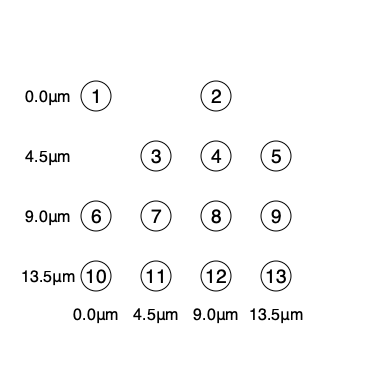

In [2]:
Random.seed!(2)
atoms = generate_sites(SquareLattice(), 4,4; scale = 4.5) |> random_dropout(0.2)

Above, we used Bloqade's pre-defined functions for creating square lattices. Bloqade has many pre-determined such lattices, for easy of use, but also takes other geometries as per the need of the user. 

So very well, the above should represent the nodes of a graph. But how do we define edges? As mentioned, two atoms that are too close together are blocked from being both in the $| 1 \rangle$, or red, state. So we will abstract the atoms that are positioned closer than a "blockade radius" distance $R_b$, under which 2 qubits cannot be simultaneously $1$, to be connected by an edge.  

For now, we can use a plotting function with fixed sizes of the blockade radius, in order to see which atoms are connected to which for a given choice of the radius,

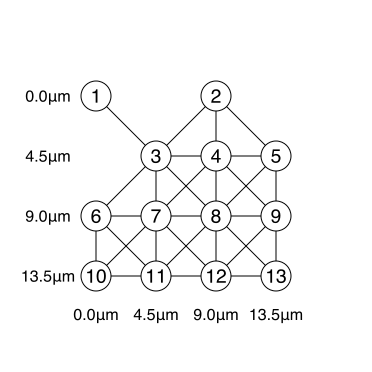

In [3]:
Rb=7.74
Bloqade.plot(atoms, blockade_radius = Rb)

Very well. Moving to step 2! We need to fix the algorithm. To solve the MIS in the graph above, this is not complicated. Adding a global heavy weight $\Delta$ to all sites should favor all qubits to be on state $| 1 \rangle$, while the Rydberg blockade should do, by itself and without need of our own control, the job of enforcing the constraint of no neighboring red nodes. 

So we can imagine initializing the graph with all states painted white, $| 0 \rangle$, and evolving a very negative global $\Delta$ towards a very positive value, with a finite $\Omega$ meanwhile to enable qubit flips from $0$ to $1$. As a subtlety,the blockade radius $R_b$ is actually a function of the Hamiltonian parameters and goes as $R_b = (C_6/\Omega)^{1/6}$, where $C_6=2\pi \times 862690\, \text{MHz}\, \mu \text{m}^6$.So we have to adjust $\Omega$ to create the correct Rydberg blockade radius for the expected connectivity. For those with some experience, you may notice that we are just defining a quantum adiabatic algorithm for this problem.

Here is how we do that with Blockade, using piecewise linear time traces for the Hamiltonian parameters.

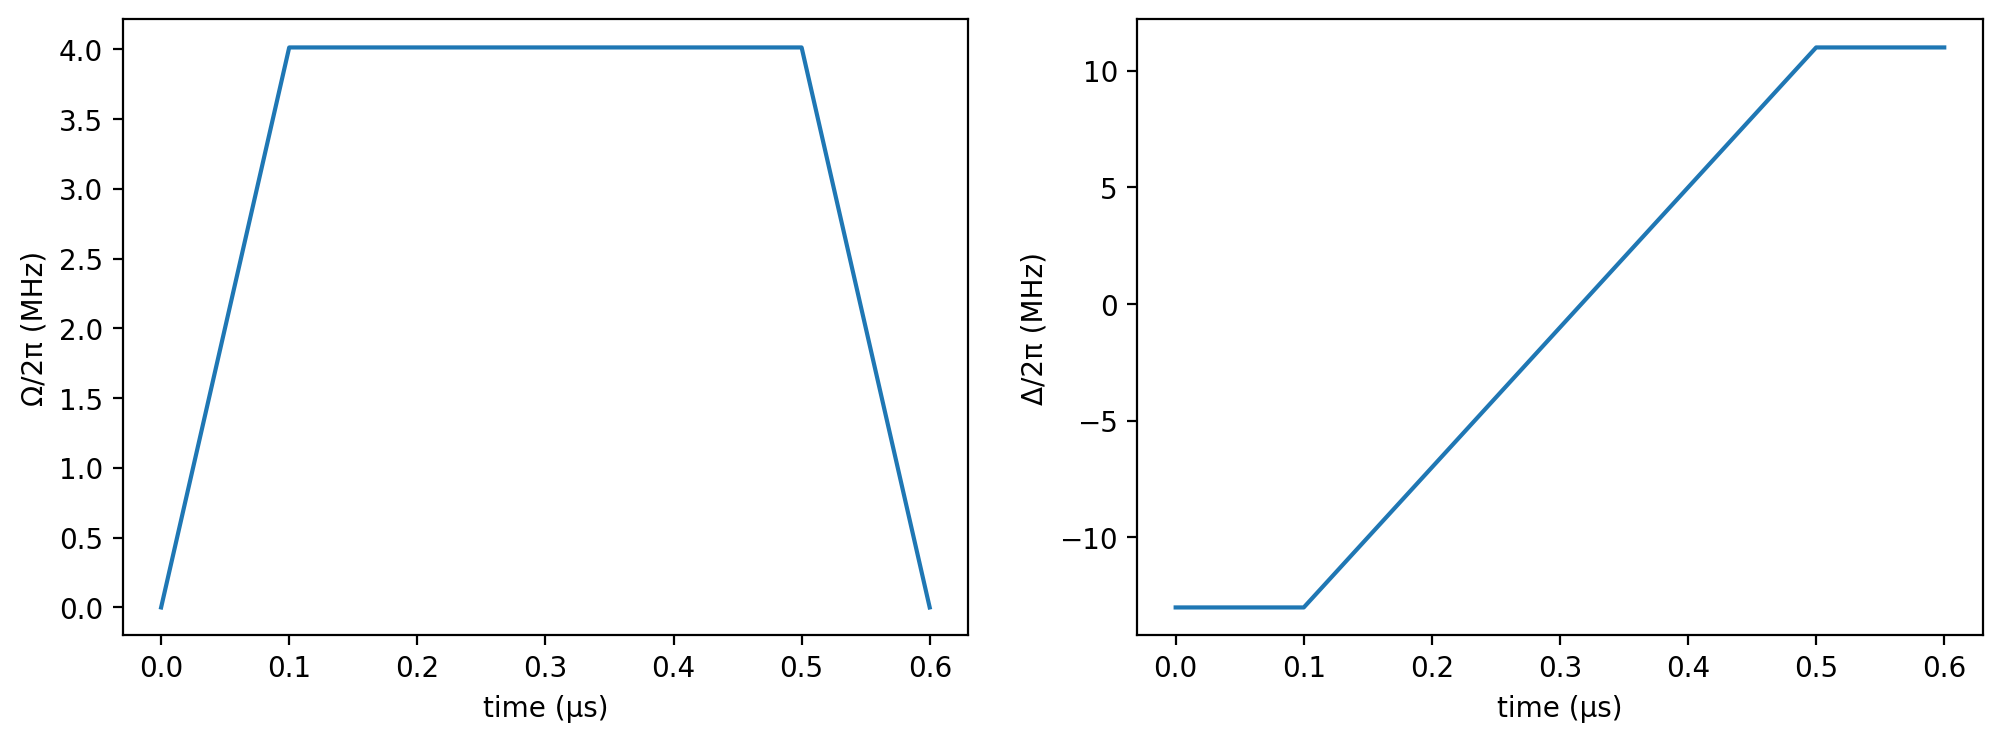

In [4]:
#Total evolution time
T_max = 0.6

#Fix Ω according to the desired Rydberg radius
C6 = 2π * 862690;
Ω_max = C6 / Rb^6 #2π * 4

#Build time traces for adiabatic algorithm
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

#Quick plot to check
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

At this point, we can emphasize that Bloqade has other internal functions that enable more complex choices of these time traces, including smooth and generally optimized traces that improve the convergence and likelihood of finding the MIS. 

Then...step 3! We simply initialize the problem with the parameters above, including a "zero_state" initial register for the Hamiltonian's qubits.

In [5]:
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian);

And step 4 cannot, be easier. We emulate the time evolution as

In [6]:
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 1.688 MiB
    expression:
nqubits: 13
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


We are done. Now it is just a matter of enjoying the results by asking questions. For example, the 10 most probable basis states contributing to $| \psi(t=T_{Max}) \rangle$ are

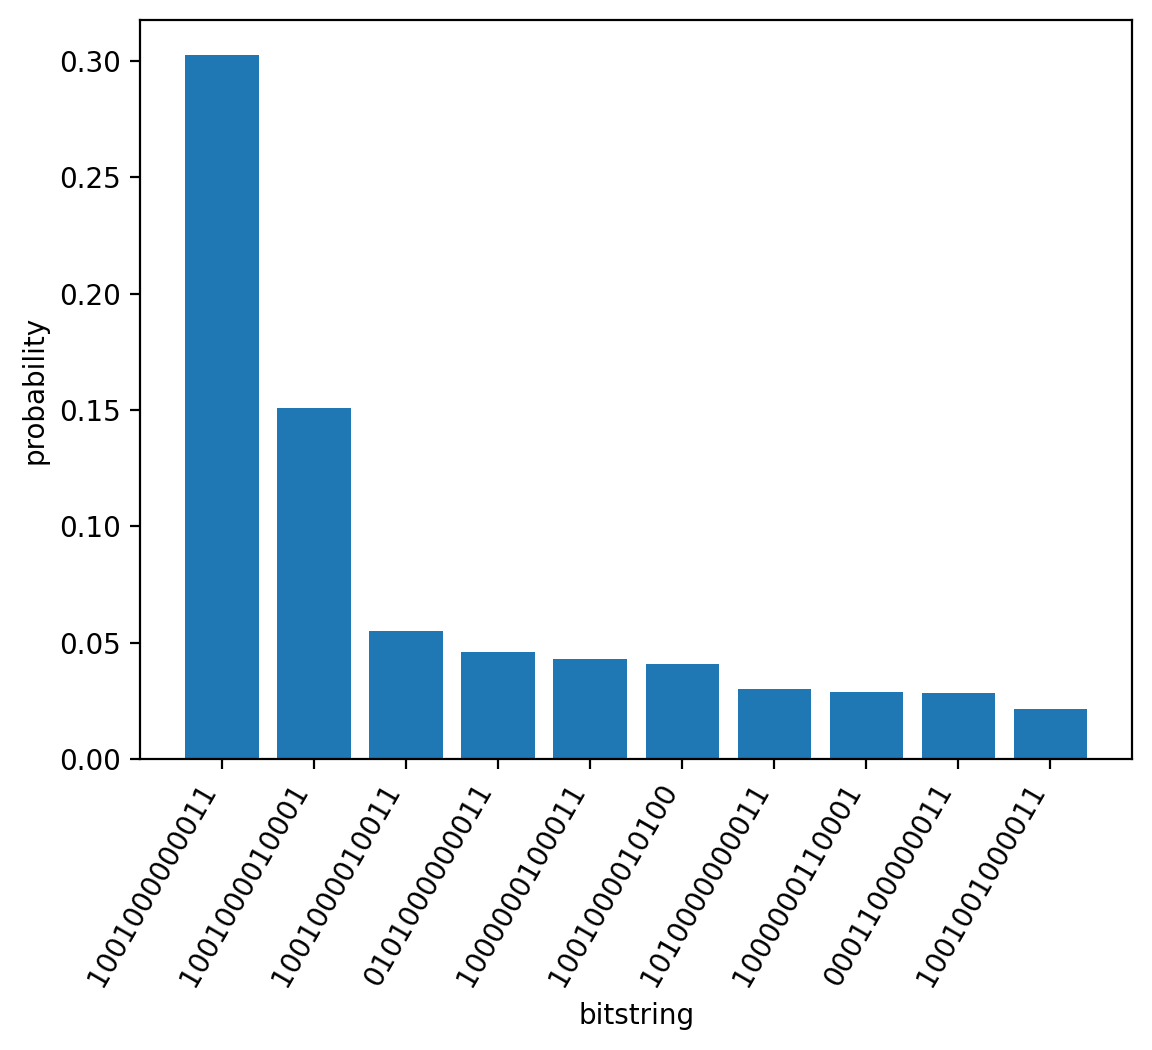

In [7]:
bitstring_hist(prob.reg; nlargest = 10)

We already see that a couple of them have larger probability than the others. Do they correspond to MIS? At this level, we can check by eye. Here are some plots of the solutions (i.e., a graph colored according to the labels of the states found above)

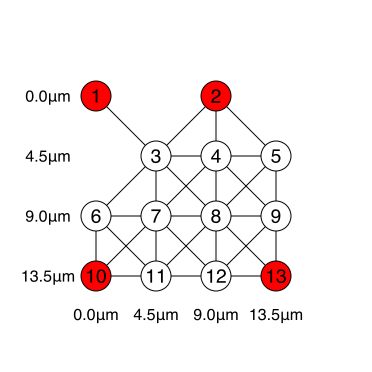

In [8]:
best_bit_strings = most_probable(prob.reg, 3)

Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

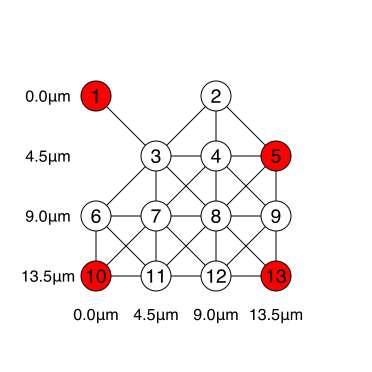

In [9]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

But note the 3rd most-likely bit string does **not** correspond to an MIS.

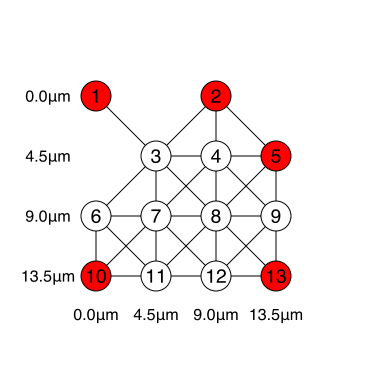

In [10]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[3]])

Nodes 2 and 5 are incorrectly colored red together. Still, this is a low-probability state, and testing whether a MIS candidate is an actual solution can be done in polynomial time for large problem instances. 

This is the end of this tutorial. Bloqade has much more options, examples, and problem-solving capacity beyond MIS problems. Visit [Bloqade](https://queracomputing.github.io/Bloqade.jl/dev/) to learn more!